# Examples of using Variable-Order Fractional Calculus (VO-FC) operators for integration and differentiation of time series signals

## Packages import

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import random


## Helper functions definitions

In [68]:
def time_vector_generator(sample_time, simulation_end_time):
    number_of_samples = int(simulation_end_time / sample_time) + 1
    print("___________________________________")
    print(f"Simulation time step: {sample_time}")
    print(f"Simulation end time: {simulation_end_time}")
    print(f"Number of simulation samples: {number_of_samples}")
    print("___________________________________")
    return np.arange(0, number_of_samples, 1) * sample_time


## Class definition of an Variable-Order Fractional Calculus (VO-FC) operator  
The class was built based on the modified Grünwald-Letnikov definition given below [[1]](https://ieeexplore.ieee.org/abstract/document/9684478)
$$
\mathscr {D}^{\alpha (t)}_{f} f(t) \approx h^{-\alpha (t)} \sum _{k=0}^{\infty } w_{k}(t) f(t-kh)
$$  
where $w_k(t)$ are coefficients that can be expressed recursively as:  
$$
\begin{align*} w_{0}(t)=&1, \\ w_{j}(t)=&\left ({1-\frac {\alpha (t)+1}{j}}\right)w_{j-1}, \quad \text {for} ~j=1,2,\ldots\tag{9}\end{align*}
$$

In [69]:
def fractional_weights(alpha, m):
    if m == 0:
        w = np.ones(1)
        return w
    else:
        w = np.zeros(m + 1)
        w[0] = 1.0
        for i in range(1, m + 1):
            w[i] = (1 - ((alpha + 1) / i)) * w[i - 1]
        return w


class VofidGl:
    __slots__ = ["order", "input_signal", "model", "step", "input_len", "model_state", "dx_dt_memory"]

    def __init__(self, order, input_signal, model):
        self.order = order
        self.step = model.ts
        self.input_signal = input_signal
        self.input_len = len(input_signal)
        self.model = model
        self.model_state = np.zeros_like(input_signal)
        self.dx_dt_memory = np.zeros_like(input_signal)

    def sim(self):
        for i in range(self.input_len - 1):
            self.dx_dt_memory[i] = self.model.sim_dx(self.input_signal[i], self.model_state[i])
            w = fractional_weights(-self.order[i], i)  # Order changes sign due to integration
            self.model_state[i + 1] = (self.step ** (self.order[i])) * (
                w @ np.flip(self.dx_dt_memory[: i + 1])
            )  # Order changes sign due to integration
        return self.model_state


## Definition of simple integrator class

In [70]:
class Integrator:
    __slots__ = ["k", "ts", "state_no"]

    def __init__(self, k, ts, state_no):
        self.k = k
        self.ts = ts
        self.state_no = state_no  # for future implementation

    def sim_dx(self, u, x):
        dx = self.k * u
        return dx


## Initialization  
Sample time selection and time vector definition 

In [71]:
dt = 0.01
time_vector = time_vector_generator(dt, 10)


___________________________________
Simulation time step: 0.01
Simulation end time: 10
Number of simulation samples: 1001
___________________________________


Creation of order and input signals

In [72]:
ord_signal = np.ones_like(time_vector)
idx = np.arange(1001)
ord_signal[idx <= 500] = 1.0
ord_signal[idx > 500] = -1.0
input_signal = np.linspace(0, 10, 1001)


Creation of integrator and VO-FC operator instances

In [73]:
integ = Integrator(k=1, ts=dt, state_no=1)
deriv = VofidGl(ord_signal, input_signal, integ)


## Simulation

In [74]:
response = deriv.sim()


## Plot of results

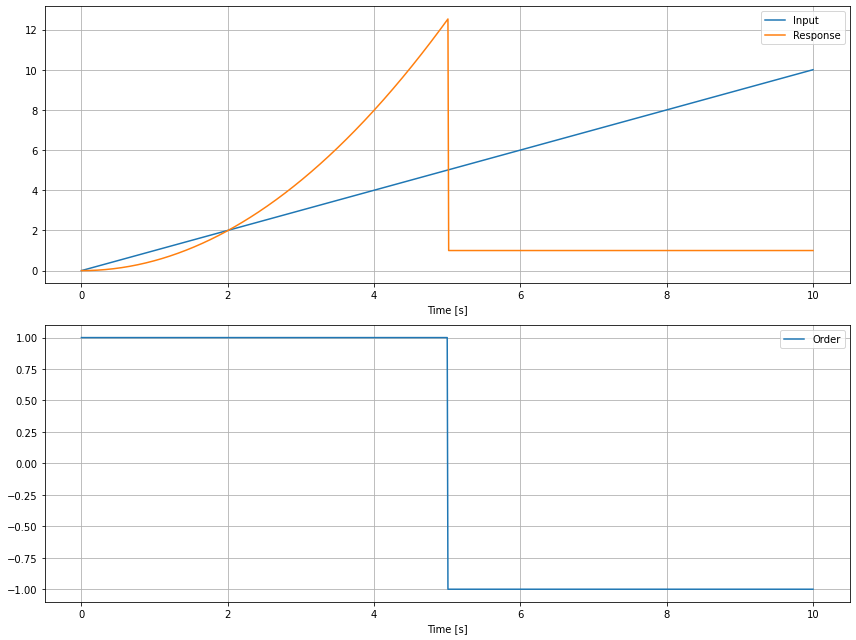

In [75]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))
axs[0].plot(time_vector, input_signal, label="Input")
axs[0].plot(time_vector, response, label="Response")
axs[1].plot(time_vector, ord_signal, label="Order")
[ax.grid() for ax in axs]
[ax.set_xlabel("Time [s]") for ax in axs]
[ax.legend() for ax in axs]
fig.set_tight_layout(True)
plt.show()


## References

[1] B. Puchalski, "Neural Approximators for Variable-Order Fractional Calculus Operators (VO-FC)," in IEEE Access, vol. 10, pp. 7989-8004, 2022, doi: [10.1109/ACCESS.2022.3143893](10.1109/ACCESS.2022.3143893).